HOUSE PRICES

Compétition:

    But
Il vous appartient de prévoir le prix de vente de chaque maison. Pour chaque identifiant de l'ensemble de test, vous devez prédire la valeur de la variable SalePrice. 

Métrique
Les soumissions sont évaluées sur Root-Mean-Squared-Error (RMSE)  entre le logarithme de la valeur prédite et le logarithme du prix de vente observé. (Prendre des journaux signifie que les erreurs de prédiction des maisons chères et des maisons bon marché affecteront le résultat de la même manière.)

# Importation des bibliothèques et des données


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config 
set_config(display='diagram')

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn import tree

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from statistics import *
import pylab 
import scipy.stats as stats

from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploration et préparation des données

In [3]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


Nous remarquons qu'il n'y a que 80 colonnes dans le test.csv, alors qu'il en a 81 dans le train.csv. 
<br/> Cela s'explique par le fait que les données de test n'incluent pas les informations sur le prix de vente final (feature SalePrice)

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Le concours repose sur la capacité à prédire le prix final de chaque maison.<br/>
À ce stade, quelques questions sont déterminante pour prédire le prix des maison, tel que:
- que savons nous sur les prix des logements ?
- quel sont les features les plus succeptibles d'incluencer le prix ?

<br/>En regardant les données, nous voyons des caractéristiques que nous attendions, comme YrSold(l'année de la dernière vente de la maison) et SalePrice. D'autres que nous n'aurions peut-être pas anticipés, tels que LandSlope(la pente du terrain sur lequel la maison est construite) et RoofMatl(les matériaux utilisés pour construire le toit). Plus tard, nous devrons prendre des décisions sur la façon dont nous aborderons ces fonctionnalités et d'autres.

# Nettoyage des données
Objectif du nettoyage des données

Le nettoyage des données comprend principalement la vérification des valeurs manquantes, la vérification des valeurs en double, la conversion des types de données et l'élimination des valeurs aberrantes.

## Valeurs manquantes

In [5]:
data= train 
data.isnull().sum().sort_values(ascending=False).head(17) *100/len(data)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
dtype: float64

<AxesSubplot:>

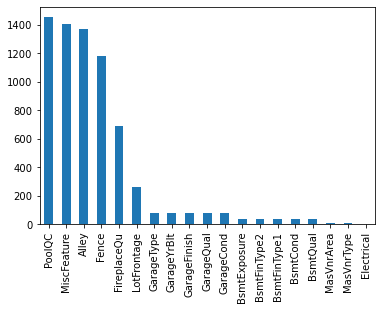

In [6]:
# création et visualisation d'une série avec le nombre de valeurs nulles par feature
null_data = data.isnull().sum() 
null_data = null_data[null_data>0]
null_data = null_data.sort_values(ascending=False)
null_data.plot.bar()

On remarque que 5 features ont un pourcentage important de valeurs manquantes. Il faudra peut-être les supprimer par la suite.

## Valeurs uniques
Jetons un coup d'œil sur la colonne, MiscFeature.

In [7]:
print ("Unique values are:", train.MiscFeature.unique())

Unique values are: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


Ces valeurs décrivent si la maison a ou non un cabanon de plus de 100 pieds carrés, un deuxième garage, et ainsi de suite. Nous pourrions vouloir utiliser ces informations plus tard. Il est important de rassembler les connaissances du domaine afin de prendre les meilleures décisions face aux données manquantes.

In [8]:
X=data.drop(columns=['Id','SalePrice'])
y=data["SalePrice"]

<AxesSubplot:>

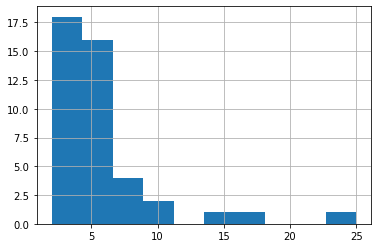

In [9]:
X.select_dtypes(include=['object']).nunique().hist()

L'histogramme montre une découpe en 3 parties:
- Il définit les zones où les modalitées sont multiples

In [10]:
X.select_dtypes(include=['object']).nunique().sum()

252

In [11]:
X.select_dtypes(include=['object']).nunique().sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
BsmtFinType2      6
Heating           6
RoofStyle         6
SaleCondition     6
BsmtFinType1      6
GarageType        6
Foundation        6
Electrical        5
FireplaceQu       5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
ExterCond         5
BldgType          5
BsmtExposure      4
MiscFeature       4
Fence             4
LotShape          4
LandContour       4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
LandSlope         3
GarageFinish      3
PavedDrive        3
PoolQC            3
Utilities         2
CentralAir        2
Street            2
Alley             2
dtype: int64

In [12]:
features_cat_all=pd.DataFrame(X.select_dtypes(include=['object']).nunique()<=5)  
len(list(features_cat_all[features_cat_all[0] == True].index))

27

In [13]:
feature_cat_small=list(features_cat_all[features_cat_all[0]==True].index)
feature_cat_small

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature']

## Vérification de la valeur en double

In [14]:
data[data.duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


Il n'y a pas de valeurs en double dans l'ensemble d'entraînement

In [15]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Valeurs nulles']
nulls.index.name = 'Feature'
nulls

,Valeurs nulles
Feature,
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


## Eliminer les valeurs abérantes
Nuage de points de 13 variables indépendantes et variable dépendante ["salePrice"] :


-  Taille du garage et prix de vente.

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

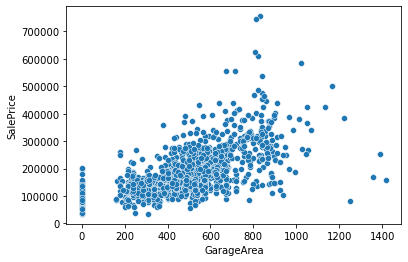

In [16]:
sns.scatterplot(x='GarageArea', y='SalePrice', data=data)

## Suppresion de valeurs abérantes

In [17]:
data = data[data['GarageArea'] < 1200]
data.shape

(1455, 81)

Nouveau dessin après avoir supprimé les outliers

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

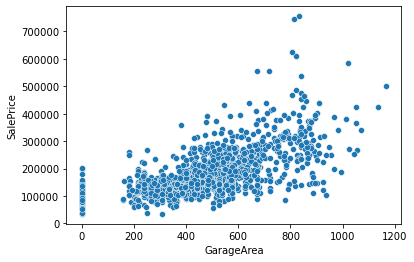

In [18]:
sns.scatterplot(x='GarageArea', y='SalePrice', data=data)

# La target

Le défi est de prédire le prix de vente final des maisons. Ces informations sont stockées dans la SalePrice colonne. La valeur que nous essayons de prédire est souvent appelée la variable cible .

In [19]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Le prix de vente moyen d'une maison dans notre ensemble de données est proche de 180,000$
<br/>Les ventes se situent entre 130,000 et 215,000. On remarque aussi, des grands écarts, ce qui laisse supposer les outliers.

## Affichage de la distribution des données des variables dépendantes
Pour construire un modèle de régression linéaire, il faut d'abord vérifier si la variable dépendante ["salePrice"] suit une distribution normale :

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

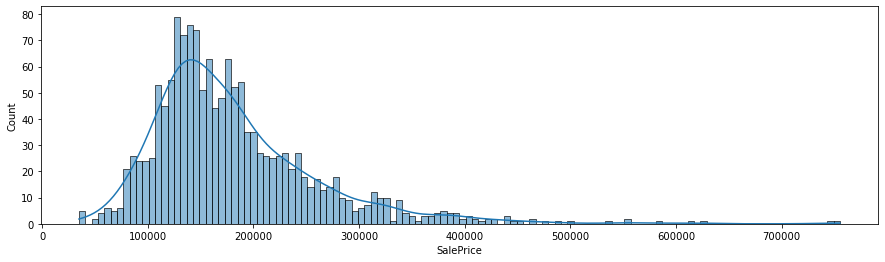

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)

sns.histplot(data=train, x="SalePrice", bins=120, kde=True)

On remarque que la distribution du prix de vente s'etend avec des valeurs extrêmes vers la droite. La distribution suit une loi relativement normale.
Regardons maintenant avec l'asymétrie de cette feature


Skew is: 1.8828757597682129


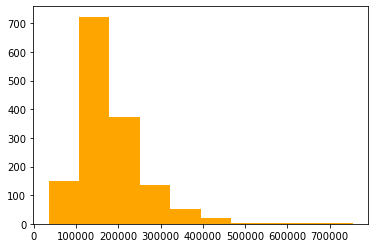

In [21]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='orange')
plt.show()

 Notez que la distribution a une queue plus longue sur la droite. La distribution est positivement asymétrique et nécessite un traitement logarithmique.

Skew is: 0.12133506220520406


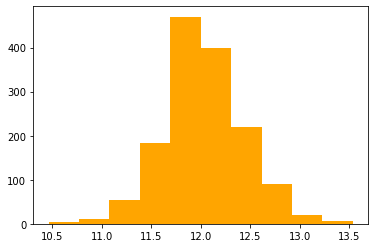

In [22]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='orange')
plt.show()

Maintenant, nous utilisons np.log()pour transformer train.SalePrice et calculer l'asymétrie une deuxième fois, ainsi que pour re-tracer les données. Une valeur plus proche de 0 signifie que nous avons amélioré l'asymétrie des données. Nous pouvons voir visuellement que les données ressembleront davantage à une distribution normale .

# Disputer les fonctionnalités numériques et catégorielles

## Les valeurs numériques

In [23]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [24]:
numeric_features.shape

(1460, 38)

In [25]:
corr = numeric_features.corr()
print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


 Ici, les 5 corrélations (ou la relations) positive ou négative avec SalePrice. Nous examinerons donc les corrélations entre les caractéristiques et la cible.

In [26]:
data.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

Les OverallQual données sont des valeurs entières dans l'interval 1 à 10 inclus.

In [27]:
quality_pivot = train.pivot_table(index='OverallQual',
                  values='SalePrice', aggfunc=np.median)
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


On cherche à approfondir la relation entre OverallQualet SalePrice par un tableau croisé dynamique.\
Nous définissons index='OverallQual'et values='SalePrice'.La médiane étant les valeurs prisent pour SalePrice

Text(0, 0.5, 'Median Sale Price')

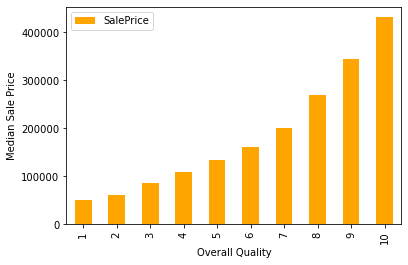

In [28]:
# Visualisation de ce tableau croisé dynamique
quality_pivot.plot(kind='bar', color='orange')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
#plt.xticks(rotation=0)plt.show()

On constate que le prix de vente médian augmente strictement à mesure que la qualité globale augmente

In [29]:
numeric_features=list(X.select_dtypes(include=['int64','float64']).columns)
numeric_features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

## Les valeurs catégorielles

In [30]:
categoricals_features=list(X.select_dtypes(include=['object']).columns)


In [31]:
categoricals_features = train.select_dtypes(exclude=[np.number])
categoricals_features.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


- La count: colonne indique le nombre d'observations non nulles
- unique: compte le nombre de valeurs uniques. 
- top: est la valeur la plus courante
- fréquence: la valeur supérieure indiquée par freq.

Pour bon nombre de ces fonctionnalités, nous pourrions vouloir utiliser un codage à chaud pour utiliser les informations pour la modélisation.
L'encodage à chaud est une technique qui transformera les données catégorielles en nombres afin que le modèle puisse comprendre si une observation particulière appartient ou non à une catégorie ou à une autre.

In [32]:
categoricals_features

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


# Preprocessing

## Ordinal Encoder
Notre modèle a besoin de données numériques, nous utiliserons donc un encodage pour transformer les données en une colonne booléenne. Création d'une nouvelle colonne encodage_street

In [33]:

categoricals_features = ['Grvl','Pave'] # catégorielles no

In [34]:
enc=OrdinalEncoder(categories= 
    categoricals_features,
    handle_unknown='use_encoded_value',unknown_value=-1)
enc

OrdinalEncoder(categories=['Grvl', 'Pave'], handle_unknown='use_encoded_value',
               unknown_value=-1)

In [35]:
test = (X["Street"]).dropna().reshape(-1,1)
enc.fit(test)

AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
final_encoder1=[[1,'Pave'],
                [0,'Grvl']
               ]

In [ ]:
enc.transform(final_encoder1)

## Stree_Encoder

In [ ]:
print ("Original: \n")
print (train.Street.value_counts(), "\n")

Dans la feature Street, les valeurs uniques sont Pave et Grvl , qui décrivent le type d'accès routier à la propriété. 
\Dans l'ensemble du dataset train, seules 5 maisons ont un accès en gravier. 

In [ ]:
train['encodage_street'] = pd.get_dummies(train.Street)
test['encodage_street'] = pd.get_dummies(train.Street)

In [ ]:
test = pd.get_dummies(train.Street)
test

In [ ]:
print ('Encoded: \n')
print (train.encodage_street.value_counts())

Les valeurs concordent. Le fait de passer des caractéristiques des données à un encodage, cela permet une utilisation dans l'apprentissage automatique et la modélisation. Maintenant, nous avons une fonctionnalité pour valeur booléennes 0- 1.

## SaleCondition_Encoder

In [ ]:
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='orange')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
#plt.xticks(rotation=0)
plt.show()

Notez que le prix de vente médian Partial est plus élevé que les autres. Nous allons encoder cela comme une nouvelle fonction. 

In [ ]:
def encode(x):
 return 1 if x == 'Partial'else 0
train['encodage_condition'] = train["SaleCondition"].apply(encode)
#test['encodage_condition'] = test["SaleCondition"].apply(encode)

In [ ]:
condition_pivot = train.pivot_table(index='encodage_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='orange')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
#plt.xticks(rotation=0)
plt.show()

# Modélisation 

## Valeurs manquantes, vérification si toutes les colonnes ont 0 valeurs nulles.

In [ ]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [ ]:
sum(data.isnull().sum() != 0)

# Construire le modèle de regression linéaire
Pour préparer les données à la modélisation:
- Séparer les caractéristiques et la variable cible. ( X= features, y=  variable cible
- Nous utilisons np.log() pour transformer la variable y pour le modèle. data.drop([features], axis=1) indique aux pandas quelles colonnes nous voulons exclure. 
- Nous n'inclurons pas SalePrice pour des raisons évidentes et Id n'est qu'un index sans relation avec SalePrice.

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
X=data.drop(columns=['Id','SalePrice'],axis=1)
y=data["SalePrice"]

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

- X_train est le sous-ensemble de nos fonctionnalités utilisées pour la formation.
- X_test est le sous-ensemble qui sera notre ensemble « retenue » – ce que nous utiliserons pour tester le modèle.
- y_trainest la variable cible SalePricequi correspond à X_train.
- y_testest la variable cible SalePricequi correspond à X_test.

### Pipeline simple, entrainement et ajustements avec RandomizedSearch()

In [ ]:
from sklearn.linear_model import RidgeCV
# Mise en place pipeline simple
model = make_pipeline(RobustScaler(),
                      RidgeCV())

model.fit(X_train, y_train)
cross_val_score(model, X_train, y_train, cv=5).mean()

## Ajout de variables catégorielles et utilisation de make_column_transformer()

In [ ]:
grid.best_score_

# Pipeline multiple

In [36]:
data = pd.read_csv('train.csv')


In [47]:
X = data.drop(['Id','SalePrice'],axis=1)
y = data['SalePrice']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (1168, 79)
Test set: (292, 79)


In [48]:
# Différenciation entre les types de features
#numerical_features = ['GrLivArea', 'GarageArea'] # numériques continues
numerical_features = X.select_dtypes(include=[np.number]).columns
#categorical_features = ['OverallQual'] # catégorielles nominales
categorical_features = X.select_dtypes(exclude=[np.number]).columns
#ordinal_features = ['OverallQual'] # catégorielles ordinales

In [49]:
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
# Mise en place pipeline pour chaque catégorie de variable

pipe_cat = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

pipe_num  =make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

preprocessing= make_column_transformer((pipe_cat,categorical_features), (pipe_num,numerical_features))


# Modélisation (entrainement)

In [51]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
lr = linear_model.RidgeCV()
pipe_lr = make_pipeline(preprocessing, lr)

In [52]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition...
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object'))])),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

## Evaluer les performance et interpréter les résultats

In [53]:
print ("R^2 is: \n", pipe_lr.score(X_test, y_test))

R^2 is: 
 0.7125561909589392


In [54]:
predictions = pipe_lr.predict(X_test)

In [55]:
predictions

array([262468.04348696, 151492.76759362, 108241.2882338 , 216933.1182231 ,
        95493.91450133,  90957.41518307, 259909.0611488 , 122466.20756519,
       514486.65987905, 161894.89539544, 214869.76011421, 119816.27409935,
       243194.21761143, 109308.85373859, 111847.22915847, 141966.61495242,
       251481.68927674, 118055.52757075, 146403.81268449, 186519.01102432,
       133920.04171925, 166393.73559822, 116856.90777833, 153707.29311475,
       197629.48177617, 172227.64769255, 165973.73908622,  56505.60615243,
       325420.87229933, 110312.64878472, 147874.67271943, 203268.38447809,
       155278.27917777, 292025.65412134, 333019.69345485, 207228.24883725,
       306225.37673915, 124270.47119041, 227053.70927919, 346249.50000516,
       203495.55343036, 104016.45425273, 204017.25392314, 303443.09042792,
       355347.57189298, 133672.45541821,  90185.71512922, 134080.34071729,
       173092.61194409,  81188.60943957, 394319.92980588, 146410.24063984,
       169095.73746802,  

In [56]:
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', np.sqrt(mean_squared_error(np.log(y_test), np.log(predictions), squared=False)))

RMSE is: 
 0.4107096426510239


In [ ]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [ ]:
#lr = linear_model.LinearRegression()
#model = lr.fit(X_train, y_train)

In [ ]:
#predictions = model.predict(X_test)

# Amélioration du modèle

## Entrainement et ajustements 

# Soumettre les résultats

In [57]:
pipe_lr.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition...
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object'))])),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [58]:
test_df = pd.read_csv('test.csv')
test1_df = test_df.drop('Id', axis=1)
test_df



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [59]:
y_pred = pipe_lr.predict(test1_df)
y_pred

array([103543.06707115, 147155.27068736, 173567.70446274, ...,
       157779.16885908, 100572.54759543, 226416.64656977])

In [60]:
y_pred

array([103543.06707115, 147155.27068736, 173567.70446274, ...,
       157779.16885908, 100572.54759543, 226416.64656977])

In [61]:
submission=pd.DataFrame({'Id':test_df['Id'],'SalePrice':y_pred})


#submite_df.to_csv("submission.csv", index=False)
submission

,Id,SalePrice
0,1461,103543.067071
1,1462,147155.270687
2,1463,173567.704463
3,1464,188211.114024
4,1465,204258.388649
...,...,...
1454,2915,72358.881253
1455,2916,75551.753105
1456,2917,157779.168859
1457,2918,100572.547595


In [62]:
submission.to_csv("submission.csv", index=False)